Skipping Other (no voxels)


C:\Users\NilGooN\AppData\Local\Temp\ipykernel_5572\3737287848.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"../figures/{roi_name}_scatter.png", dpi=300)


✅ Saved rsa_weighted.csv


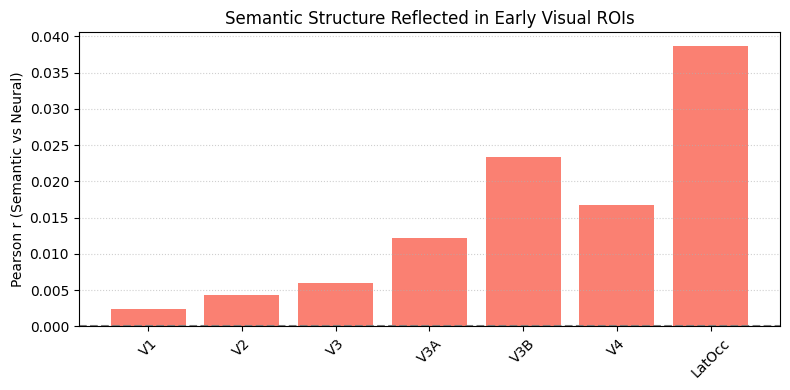

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- Load label data ---
labels = np.load("../data/kay_labels.npy", allow_pickle=True)
if labels.shape[0] == 4:
    labels = labels.T
labels = labels.astype(str)
label_data = labels[:, :4]  # All 4 semantic levels

# --- Compute weighted label similarity matrix ---
n_images = label_data.shape[0]
weights = [4, 3, 2, 1]
label_similarity = np.zeros((n_images, n_images))
for i in range(n_images):
    for j in range(n_images):
        score = sum(weights[k] for k in range(4) if label_data[i, k] == label_data[j, k])
        label_similarity[i, j] = score

# --- Load fMRI data ---
data = np.load("../data/kay_images.npz")
responses = data["responses"]
roi = data["roi"]
roi_names = data["roi_names"]

# --- Prepare output folders ---
os.makedirs("../results", exist_ok=True)
os.makedirs("../figures", exist_ok=True)

# --- RSA loop across ROIs ---
results = []
iu = np.triu_indices(n_images, k=1)

for roi_idx, roi_name in enumerate(roi_names):
    voxel_mask = (roi == roi_idx) if roi.ndim == 1 else (roi[0] == roi_idx)
    if voxel_mask.sum() == 0:
        print(f"Skipping {roi_name} (no voxels)")
        continue

    responses_roi = responses[:, voxel_mask]
    brain_corr = np.corrcoef(responses_roi)

    flat_label_sim = label_similarity[iu]
    flat_brain_corr = brain_corr[iu]

    # Compute correlation
    rho = np.corrcoef(flat_label_sim, flat_brain_corr)[0, 1]
    results.append({"ROI": roi_name, "rho": rho})

    # --- Plot scatter and save ---
    plt.figure(figsize=(6, 4))
    plt.scatter(flat_label_sim, flat_brain_corr, alpha=0.25, color='steelblue', edgecolors='none')
    z = np.polyfit(flat_label_sim, flat_brain_corr, 1)
    p = np.poly1d(z)
    plt.plot(flat_label_sim, p(flat_label_sim), "r--", label="Linear Fit")
    plt.xlabel("Semantic Similarity (Weighted)")
    plt.ylabel("Brain Similarity (Pearson)")
    plt.title(f"{roi_name} — Semantic vs Brain Similarity")
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../figures/{roi_name}_scatter.png", dpi=300)
    plt.close()

# --- Save results to CSV ---
df = pd.DataFrame(results)
df.to_csv("../results/rsa_weighted.csv", index=False)
print("✅ Saved rsa_weighted.csv")

# --- Plot bar chart of RSA results ---
plt.figure(figsize=(8, 4))
plt.bar(df["ROI"], df["rho"], color='salmon')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Pearson r (Semantic vs Neural)")
plt.title("Semantic Structure Reflected in Early Visual ROIs")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig("../figures/rsa_barplot.png", dpi=300)
plt.show()